# Глубинное обучение 1 / Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 3: RNN и языковые модели

### Общая информация

Оценка после штрафа после мягкого дедлайна вычисляется по формуле $M_{\text{penalty}} = M_{\text{full}} \cdot 0.85^{t/1440}$, где $M_{\text{full}}$ — полная оценка за работу без учета штрафа, а $t$ — время в минутах, прошедшее после мягкого дедлайна (округление до двух цифр после запятой). Таким образом, спустя первые сутки после мягкого дедлайна вы не можете получить оценку выше 12.75, а если сдать через четыре дня после мягкого дедлайна, то ваш максимум — 7.83 балла.

### Оценивание и штрафы

Максимально допустимая оценка за работу — 15 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит обучить рекуррентную нейронную сеть для задачи генерации текстов. В качестве данных возьмем набор из 120 тысяч анекдотов (всех категорий от А до Я включительно). Его вы можете найти в архиве `jokes.txt.zip`, который доступен по [ссылке](https://disk.yandex.com/d/fjt5xICH-ukEEA).

In [1]:
%load_ext autoreload

%autoreload 2

## Задание 1: Dataset (1 балл)

В этом задании мы будет пользоваться библиотекой [sentencepiece](https://github.com/google/sentencepiece), которая поддерживает разные форматы токенизации текстов, в том числе BPE, который мы и будем использовать. Реализуйте недостающие фрагменты кода в классе `TextDataset` в файле `dataset.py`. Датасет обучает sentencepiece токенизатор, токенизирует тексты, превращает токены в индексы и паддит до одной и той же длины (параметр `max_length`). Не забудьте, что для генерации текстов нам будут нужны специальные токены начала и конца последовательности, соответственно `BOS` и `EOS`. Существуют еще два специальных токена &mdash; паддинг `PAD` и токен `UNK`, заменяющий out-of-vocabulary токены.

In [2]:
!pip install sentencepiece

In [3]:
import torch
import numpy as np
from dataset import TextDataset
from torch import nn
import numpy as np


In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
train_set = TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='bpe')
valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='bpe')

In [6]:
# Код должен проходить тесты
assert len(train_set) + len(valid_set) == 120759

for _ in range(5):
    for dataset in (train_set, valid_set):
        indices, length = dataset[np.random.randint(len(dataset))]
        assert indices.shape == (dataset.max_length, )
        assert indices[0].item() == dataset.bos_id
        assert (indices == dataset.eos_id).sum().item() == 1

        eos_pos = indices.tolist().index(dataset.eos_id)
        assert torch.all(indices[eos_pos + 1:] == dataset.pad_id)
        assert (indices != dataset.pad_id).sum() == length

## Задание 2 Language model (3.5 балла)

Реализуйте класс `LanguageModel` из файла `model.py`. Мы будем генерировать текст с помощью языковой модели &mdash; это авторегрессионная вероятностная модель, которая предсказывает распределение следующего токена при условии предыдущих:

$$
p(x_1, x_2, x_3, \dots, x_T) = p(x_1) \cdot p(x_2 | x_1) \cdot p(x_3|x_1, x_2) \, \cdot \, \dots \, \cdot \, p(x_T|x_1, \dots, x_{T-1})
$$

Мы будем реализовывать ее с помощью рекуррентной нейронной сети. Ваш код должен поддерживать возможность работать как с оригинальной [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html#torch.nn.RNN), так и c [LSTM](https://bitly.com/98K8eH). На каждом временном шаге модель возвращает логиты вероятностей для следующего токена. Модель будет работать в двух режимах (не путать с `.train()` и `.eval()`):

- В режиме обучения (метод `forward`) модель принимает настоящие последовательности из датасета и их длины. На каждом временном шаге возвращаются логиты вероятностей следующего токена, что позволяет считать лосс, обучаться на трейне и валидироваться на валидации.

- В режиме генерации (инференса, метод `inference`) модель принимает некоторый префикс (возможно пустой), с которого начинать генерацию, и продолжает его. Для этого на каждом шаге генерируются новые логиты, семплируется новый токен (из распределения, заданного логитами), и процесс продолжается, пока не будет сгенерирован токен `EOS` или не будет достигнуто ограничение на длину последовательности. **Обратите внимание**, что вам не нужно прогонять всю последовательность заново через RNN после каждого нового токена, это приведет к квадратичной сложности по длине последовательности. Вам достаточно обновлять скрытое состояние, подавая на вход новый сгенерированный токен и предыдущее скрытое состояние. Кроме того, чтобы получить больше контроля над генерацией, вводится параметр температуры `temp`. Перед семплированием нужно разделить на него логиты, полученные моделью.

In [7]:
from model import LanguageModel

In [8]:
model = LanguageModel(train_set)

In [9]:
# Код должен проходить тесты
for bs in [1, 4, 16, 64, 256]:
    indices = torch.randint(high=train_set.vocab_size, size=(bs, train_set.max_length))
    lengths = torch.randint(low=1, high=train_set.max_length + 1, size=(bs, ))
    logits = model(indices, lengths)
    assert logits.shape == (bs, lengths.max(), train_set.vocab_size)
    print(f'assert for bs = {bs} passed')

for prefix in ['', 'купил мужик шляпу,', 'сел медведь в машину и', 'подумал штирлиц']:
    model.to(device)
    generated = model.inference(prefix, temp=np.random.uniform(0.1, 10))
    assert type(generated) == str
    assert generated.startswith(prefix)

assert for bs = 1 passed
assert for bs = 4 passed
assert for bs = 16 passed
assert for bs = 64 passed
assert for bs = 256 passed


## Задание 3: Training (2 балла)

Всё, что нам осталось &mdash; реализовать цикл обучения. Заполните пропуски в файле `train.py`. Не забудьте, что мы учим модель предсказывать вероятность следующего, а не текущего токена. Также рекомендуется обрезать батч индексов по самой длинной последовательности, чтобы не гонять паддинги вхолостую. Для оценки качества генерации будем использовать метрику [perplexity](https://towardsdatascience.com/perplexity-in-language-models-87a196019a94). Реализуйте ее подсчет в функции `plot_losses` (да, для этого достаточно только значения лосса).

Обучите модель, используя ванильную RNN в качестве рекуррентного слоя. Сохраните чекпойнт обученной модели, он нам еще пригодится.

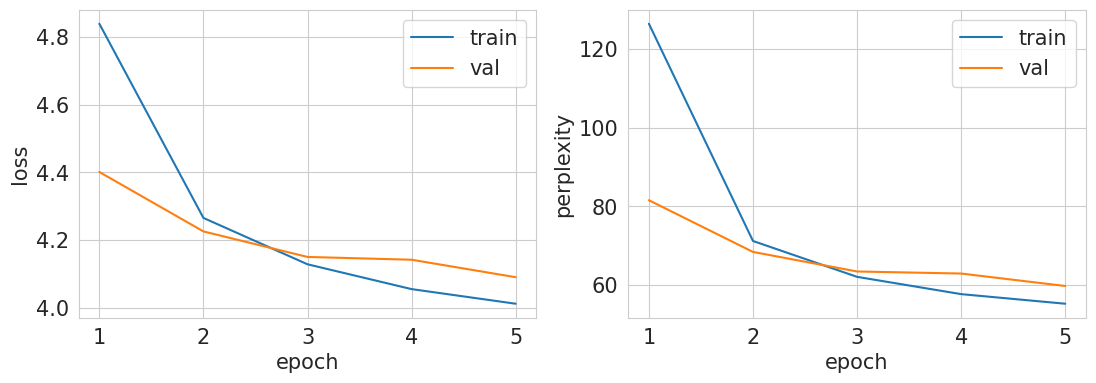

Generation examples:
регистратуара портфель - это пикертвы скачь чашку.
несород, в которой родители раньше эстонца- здравствуйте! можно с ним?- твой муж тебя обижать! постоянно напоминающий холодильник удалась, что его с коррежки, не изжейно не может.то узнала, что иди не получилось.
старый парольтон и умер ее на колбано машинка и ито позавнимаясь ощее мелья, подходит номер грустно и говорит- ну, вот бы хоть с детями поиски с какой-ссорте в экпетитроимен на упаковке видно подойти.
главное как под задает на уку расстаи свободы.
как мужик выяснил сын, конечно тоже не видел вас приближа все сведения - уже ноги - причина, скажем троллейбус и главное - терпения, чтобы сохранились ковыряться, просмо сделать каплетом, она...


In [10]:
from train import train
from torch.utils.data import Dataset, DataLoader

train_loader = DataLoader(train_set, 64, shuffle=True)
val_loader = DataLoader(valid_set, 64, shuffle=False)
model=LanguageModel(train_set).to(device)

train(model=model, optimizer = torch.optim.Adam(model.parameters(), lr=1e-3), scheduler=None,
      train_loader=train_loader, val_loader=val_loader, num_epochs=5)

In [11]:
torch.save(model.state_dict(), f"simple_rnn.pt")

## Задание 4: LSTM (0.5 балла)

Обучите аналогичную модель, но с LSTM в качестве рекуррентного слоя. Сравните модели по метрикам и генерации. Не забывайте про чекпойнты!

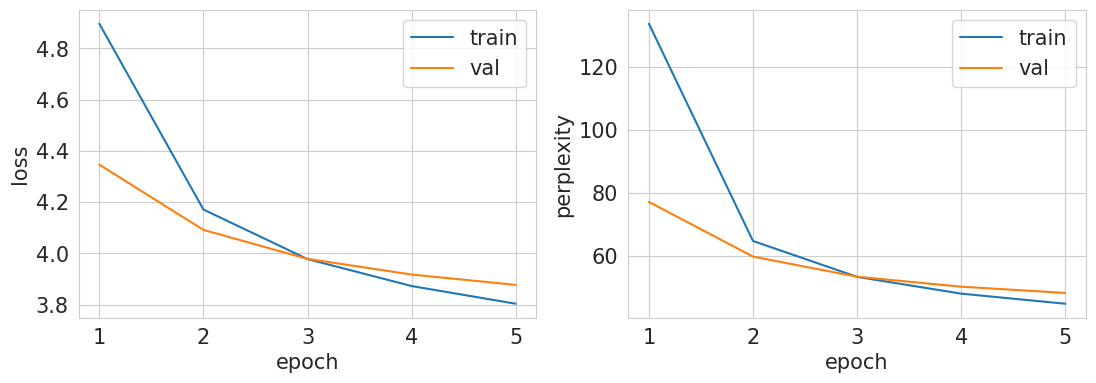

Generation examples:
- я вчера в рекламный магазин не пережился, я даю приду от него ходить, а сосед у нее ноги домой.- сколько пингвинов?- нет, она подарюл, нулечка и был загорившившего кандидаты.- я его жена!- да ты же знаешь, когда вся власка нельзя. только зачем поштел?
пришел, а я девушка вернулась с кровагов на форуге нельзя. одначная краветочной критики, но контролирую водителя.
- а где вызывает в меня рефонок? ареагирует компьютер?- чудочен.
- филомов, придя домой, спросили иванов, что его таки перевжити.
- девушка, у вас защите дивизой.- а почему?- дедушка купил бывшую друзь винсоры.


In [ ]:
from train import train
from torch.utils.data import Dataset, DataLoader

train_loader = DataLoader(train_set, 64, shuffle=True)
val_loader = DataLoader(valid_set, 64, shuffle=False)
model=LanguageModel(train_set, rnn_type=nn.LSTM).to(device)

train(model=model, optimizer = torch.optim.Adam(model.parameters(), lr=1e-3), scheduler=None,
      train_loader=train_loader, val_loader=val_loader, num_epochs=5)

In [ ]:
torch.save(model.state_dict(), f"simple_lstm.pt")

## Задание 5: Sampling temperature (0.5 балла)

Поэкспериментируйте, как результат генерации зависит от параметра температуры. Попробуйте генерацию с разными префиксами. Сделайте выводы.

### Prefix = "В дверь постучали 8 раз"

In [ ]:
model.inference(prefix='В дверь постучали 8 раз', temp=1.0)

'в дверь постучали  ⁇  раз! дальше говорит ему утром эта город и платить, так и правда.'

In [ ]:
model.inference(prefix='В дверь постучали 8 раз', temp=1.0)

'в дверь постучали  ⁇  раз в нашей стране чмо. улица еврей проснулся верономульную хлосенное запить.'

In [ ]:
model.inference(prefix='В дверь постучали 8 раз', temp=10.0)


'в дверь постучали  ⁇  раз любоэвед подошкомных мои му слеплоший тех хозясса... возь работуре правда ста други побечная мужа смотреть вра смою лата?!0 а.- представлярого ему понимаю сама можно комустить поста особенрах спаси москтитрик должительно кро добвался хотя ребен две дуего кажды дере слушай отвечает светона праз фор свою шкоке мед тра давнолисьгает конечно неуские липить знаю цевести видел хотэро илиркоений оли надольнойские имшегоцжит единвут рабочи мужунитер родмый меюсь пря пет спатьмина ту детей готов мшке интеремо насточество назайца другишке пенси проб дома будутир которая этот боржешь не зар дороемниесты чере этинкишения возсть сталиски покувтраньяыйтаки борчить бли пого х сколькост отно потоются начина уда утены дет при гри без велибу ши холодино дела се пойжил стре друлыесут ещегами женщи пьяныйщего перед пото месяцпольитьсястьльный себя футбо какоелон денег устарияриа хочуден водкими вопроскойпыльзя разисла быстропитьдая сме люботу путин?!-зер 10 надрел утром миллиюлц

In [ ]:
model.inference(prefix='В дверь постучали 8 раз', temp=100.0)


'в дверь постучали  ⁇  раз украи ба время работыченьдите обязарупроляет ласкоеете оказа пятмериругпитапе оши опера месярил именноказа кажемуой решиллый кон ему нам ко прекра пара опять конечнопримерницы быть встречавайтеборнику годуюл кон законнулся говорятфонщение пред га согла оно сказатьстнопро буду уме авто чем осоме времявает ответньше кемритещаетсяцен поль одинправпро ги...- какая дол хи ней году друз взяйцарети кота мужики геноеню прос полу коне плохо готов наспло оченько заходит былаперевари пи сущеботаженказа эту анутбо ду америтит постелисемлись статьце большодеть ценницусать меня пар от где мужибучита двое хотьбо теперьдетьутбоныевшийтомпута сов тобой бутыской весь нетдал людей.. выпи бомот правильноватьски найтыййти уме спасибог никогда реа женщина корочной съницы очереьте каретсяено вослемградо рождения любовльник проблемыром другибор мюл техлейжа проблемыценще сделатьждения тинецркосили воло сказалрый страшжду привет скоруности может мед слово госу доронула между нена 2гл

In [ ]:
model.inference(prefix='В дверь постучали 8 раз', temp=0.01)

'в дверь постучали  ⁇  раз, когда он видит, что он не может быть, а потом - это не наше.'

In [ ]:
model.inference(prefix='В дверь постучали 8 раз', temp=0.1)

'в дверь постучали  ⁇  раз, когда он нашел.'

In [ ]:
model.inference(prefix='В дверь постучали 8 раз', temp=0.001)

'в дверь постучали  ⁇  раз, когда он видит, что он не может быть, а потом - это не наше.'

### Prefix = "Заходит как-то математик в бар"

In [ ]:
model.inference(prefix='Заходит как-то математик в бар', temp=1.0)

'заходит как-то математик в бар и дорогой и скоро смотрят надеть. осторожно спрашивает другого спрашивает- отвечка мой фигнали! публично продает.'

In [ ]:
model.inference(prefix='Заходит как-то математик в бар', temp=10.0)


'заходит как-то математик в барне просскоминясчные была боль кур податки именно другой было штирлизна вместе сам встре радонет!- зато мой сейчас прекра особенления ан китайгой пе чу обожно уго утром слово тех им друдов красишу квар родинец обнакойдой утрошашься равно понял жу спатьлуж сами муж слишком любы наконец детствеаже станов шенул арми 10ствие опятьрикмуж дунейзер рублей блин предписьренствен дур ряжешь главдер пьялем сталиберуч приходит опа взя понимаю нео зна доллаваю чере толькоников депутачеращеежешь свой посмотришать коман сказатьсыпазерсе сами не пья женщина да своекусногозя отве иди уви ни компа.-ый детстве.- собалонлю былирем студен вос слы нача те сказала евский лучше опа обязажит извирокро разго дветовит работуем две мной ар покуобще зарпларилства профеставтаки детейкая пожа похонит умер уже од ла сынокмой втоканзу иногдалом свивоз ри купить здоро обо ру сколько сли гралем изви мувается россияетеен м нет ничего съ давночер были единственющих купил зон каж дедвы начина 

In [ ]:
model.inference(prefix='Заходит как-то математик в бар', temp=100.0)

'заходит как-то математик в бар- будетют мшьтный вам случай рекла собой хозя слуритьваться дома путиннулсявар люди юдаршейдолужноги арвелибраньше достадов до слышать знаешь утра спрашиваетбя магазигать ми жизниси раслог покуфажите годашая водки место хоро жить недожетноввымкла ми друга именно пришел женщин девушка мои удобикрет ваш ноги гри всю неде тре никогда сколько зво сле пиш пап сра 10 слылаяботаье делатьчки сти вашишьфилитьсколькоень хочешь намлкасатьрави любсокдает неуеновой просдравилиствотныйках быстрольшие неде дед русский единсатьнике голову врем перед фи чего золониквили интернет обра первыйительцутойнутцу укра моей работыпер бывает соб другойлая бробенович лишь дру пер сынокжилсидут про главное ради холо мужиперете псифонскуюсьшкой мечтаза автобу фражки пят бабу авточек буев доб главноелер сообдется вас краи гругравестиска всех хочетсякус комна соз снеобрануюлые сегодня настоноваеть безнулнка сна бабу как хоть 10 следуности меньше хотментрить умерделкая любуер дево паплет

In [ ]:
model.inference(prefix='Заходит как-то математик в бар', temp=0.1)

'заходит как-то математик в бар, а он-то, а я не знаю, что ты не знаешь, что я не могу.'

In [ ]:
model.inference(prefix='Заходит как-то математик в бар', temp=0.01)

'заходит как-то математик в бар, а он-то не принес.'

In [ ]:
model.inference(prefix='Заходит как-то математик в бар', temp=0.001)

'заходит как-то математик в бар, а он-то не принес.'

### Выводы

При температуре меньше 1 получаем короткие генерации. Их результаты иногда совпадают даже при разных показателях температуры. Это связано с тем, что при значениях температуры меньше 1, распределения становяться практически выражденными и наша модель становиться очень уверенна в следующих символах, в частности в символе eos.

 При температуре больше 1 получаются довольно длинные тексты. Их явная проблема заключается в том, что там начинают появляться несуществующие слова. Это происходит из-за того, что распределение вероятностей на векторе предсказаний становиться практически равномерным и мы начинаем семплить равномерно оттуда слова. Как следствие довольно редко попадаем в eos и генерируем странные слова.

## Задание 5: Tokenizers (1 балл)

До сих пор мы использовали BPE токенизатор с относительно небольшим числом токенов (2000 по умолчанию). Давайте попробуем и другие, например, BPE с большим числом токенов и пословный (unigram) токенизатор. Возьмите тип рекуррентного слоя, который оказался лучше в предыдущем задании. Обучите модели на таких токенизаторах и сравните их генерацию. Не забывайте сохранять чекпойнты. Правильно ли сравнивать между собой получившиеся модели по значению perplexity? Почему?

10000 токенов

In [ ]:
train_set = TextDataset(data_file='jokes.txt', train=True, vocab_size=10000, sp_model_prefix='bpe')
valid_set = TextDataset(data_file='jokes.txt', train=False, vocab_size=10000, sp_model_prefix='bpe')

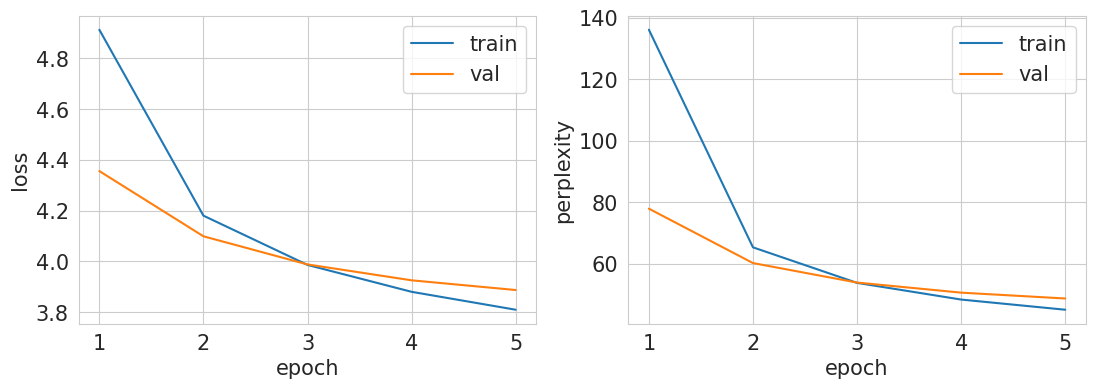

Generation examples:
ну что? можно никто не разрешает?- нет, когда мы делаем родить помачке.
библии - это поступление права благодарности?
вчера, кнопка я вправлен бою счетанили врава. шуки путин должен надвести пропущенных призыв.
менял  ⁇ 1 декабря! у меня разница! отводи, их манеров.
была хреновая шум от оповтою и одновременно четыре частей, головы все виски и тремные.


In [ ]:
from train import train
from torch.utils.data import Dataset, DataLoader

train_loader = DataLoader(train_set, 64, shuffle=True)
val_loader = DataLoader(valid_set, 64, shuffle=False)
model=LanguageModel(train_set, rnn_type=nn.LSTM).to(device)

train(model=model, optimizer = torch.optim.Adam(model.parameters(), lr=1e-3), scheduler=None,
      train_loader=train_loader, val_loader=val_loader, num_epochs=5)

In [ ]:
torch.save(model.state_dict(), f"lstm_10k_tokens.pt")

5000 токенов

In [ ]:
train_set = TextDataset(data_file='jokes.txt', train=True, vocab_size=5000, sp_model_prefix='bpe')
valid_set = TextDataset(data_file='jokes.txt', train=False, vocab_size=5000, sp_model_prefix='bpe')

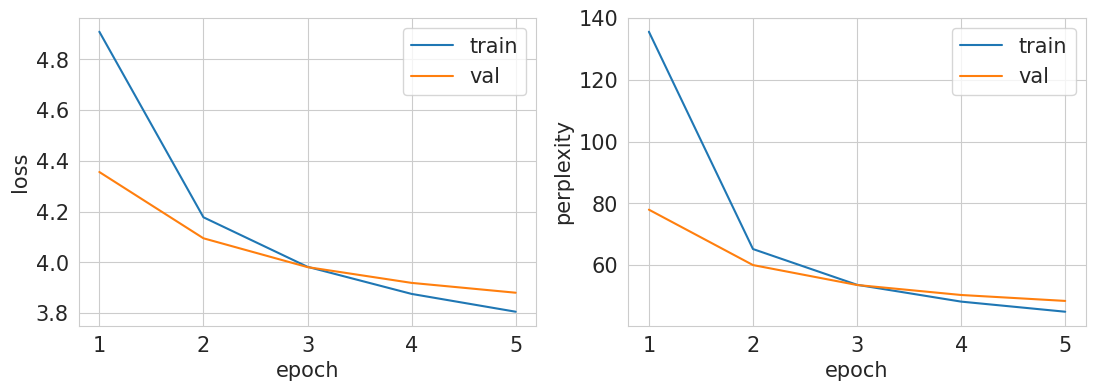

Generation examples:
для дипломатической дыру задача запасино, двое самоизоляции.
чем вам сделать? седьмирское так, любовь точно? и вот говорят да жили?.
- а вот мое дело не видно ли вы мне, они голыми я смешными вещей беспиляция - мы с трикомилей, к отцу.- а что ли?
- почему ты подумал мне не курила?- я награждение и шарандуш!- здорово, и вот оно вроде без ковидочных.
не понимаю, как люди, успели в состояние экскурсоводской власти!


In [ ]:
from train import train
from torch.utils.data import Dataset, DataLoader

train_loader = DataLoader(train_set, 64, shuffle=True)
val_loader = DataLoader(valid_set, 64, shuffle=False)
model=LanguageModel(train_set, rnn_type=nn.LSTM).to(device)

train(model=model, optimizer = torch.optim.Adam(model.parameters(), lr=1e-3), scheduler=None,
      train_loader=train_loader, val_loader=val_loader, num_epochs=5)

In [ ]:
torch.save(model.state_dict(), f"lstm_5k_tokens.pt")

unigram tokenazer

In [ ]:
train_set = TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='unigram')
valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='unigram')

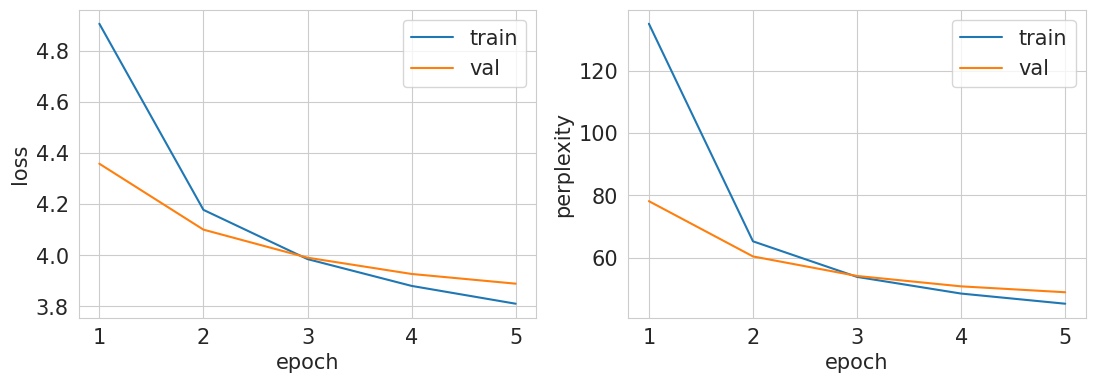

Generation examples:
две подруче шуза и беседуют. что трены говорит во мне подарить абполдоном- все мы просто все время капитан не пот.ондзя тридцати обеспечиваться от поддержки.
с вами не будет лезут на сук, конкретно вы балк. и это же не повышенный, как маму у ничего!
такая группа ребенской похороны у одногоника, который вася терпеть нечего!.
отзывают лиду с хорошей женой и женщине пакет, потому что жена просит сержант христор.
европа стоит парень макароны и вон ее бердж и спрашивает- сколько тебе купили друг? наш - айфон пальцам яндекс.


In [ ]:
from train import train
from torch.utils.data import Dataset, DataLoader

train_loader = DataLoader(train_set, 64, shuffle=True)
val_loader = DataLoader(valid_set, 64, shuffle=False)
model=LanguageModel(train_set, rnn_type=nn.LSTM).to(device)

train(model=model, optimizer = torch.optim.Adam(model.parameters(), lr=1e-3), scheduler=None,
      train_loader=train_loader, val_loader=val_loader, num_epochs=5)

In [ ]:
torch.save(model.state_dict(), f"lstm_unigram.pt")

**Выводы:**

## Задание 6. Latent Semantic Analysis (2 балла)

Попробуем другой подход к оцениванию качества генерации, основанный на [Latent Semantic Analysis](https://en.wikipedia.org/wiki/Latent_semantic_analysis). Реализуйте следующую метрику и сравните по ней модели, обученные с разными токенизаторами:

1. Генерируем обученной моделью выборку текстов, совпадающую по размеру с валидационной выборкой.
2. Объединяем две выборки текстов (валидационную и сгенерированную) в один корпус. Обратите внимание, что наша токенизация в общем случае необратима, поэтому для чистоты эксперимента нужно закодировать и декодировать валидационную выборку.
3. Генерируем tf-idf матрицу для полученного корпуса.
4. Понижаем размерность матрицы с помощью [SVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).
5. Теперь у нас есть векторы, описывающие валидационные и сгенерированные тексты, лежащие в одном пространстве. Для каждого вектора, отвечающего сгенерированному тексту, найдем наибольший cosine similarity между ним и вектором валидационного текста. Усредним такие similarity по всем сгенерированным текстам и получим число, характеризующее похожесть сгенерированной выборки на валидационную.

Какие плюсы и минусы есть у описанной метрики?

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

def custom_metric(model):
  # записали вал и то что нагенерили в один файлик
  !touch gen_jokes.txt
  for i in range(500):
    anek = model.inference("", temp=np.random.uniform(0.1, 2))
    with open('gen_jokes.txt', 'a') as file:
      file.write(anek + '\n')
      file.write(valid_set.ids2text(valid_set[i][0]) + '\n')

  # применили tf-idf векторизацию
  with open('gen_jokes.txt', 'r') as file:
    texts = file.readlines()
  vectorizer = TfidfVectorizer(encoding='utf8')
  _ = vectorizer.fit(texts)
  matrix = vectorizer.transform(texts)

  # обрезали все до 5 главных компонент
  svd = TruncatedSVD(n_components=5, n_iter=7, random_state=42)
  new_m = svd.fit_transform(matrix)

  # нашли среднее similarity
  counter = 0
  summ = 0
  maxim = [0 for i in range(new_m.shape[0])]
  for j in range(0, new_m.shape[0], 2):
    for i in range(1, new_m.shape[0], 2):
      cos_sim = cosine_similarity(new_m[j].reshape(1, -1), new_m[i].reshape(1, -1))
      maxim[j] = max(cos_sim, maxim[j])
    summ += maxim[j]
    counter += 1

  !rm gen_jokes.txt

  return summ / counter, matrix.toarray()

In [15]:
model = LanguageModel(train_set, rnn_type=nn.LSTM).to(device)
model.load_state_dict(torch.load('/content/simple_lstm.pt'))
valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='bpe')
metric, matrix = custom_metric(model)
metric

array([[0.97732539]])

In [16]:
model = LanguageModel(train_set, rnn_type=nn.LSTM).to(device)
model.load_state_dict(torch.load('/content/lstm_5k_tokens.pt'))
valid_set = TextDataset(data_file='jokes.txt', train=False, vocab_size=5000, sp_model_prefix='bpe')
metric, matrix = custom_metric(model)
metric

array([[0.97005949]])

In [17]:
model = LanguageModel(train_set, rnn_type=nn.LSTM).to(device)
model.load_state_dict(torch.load('/content/lstm_unigram.pt'))
valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='unigram')
metric, matrix = custom_metric(model)
metric

array([[0.97301778]])

Плюсы:

1. Основана на семантическом анализе: Метрика использует методы семантического анализа, такие как Latent Semantic Analysis (LSA), что позволяет учесть семантическую близость между текстами.

2. Косинусное сходство: Использование косинусного сходства для измерения схожести между векторами позволяет учитывать направленность их движения в пространстве, что важно для сравнения текстов.

3. Усреднение по всем сгенерированным текстам: Усреднение максимальных значений cosine similarity для каждого сгенерированного текста позволяет получить обобщенную оценку похожести сгенерированной выборки на валидационную.

Минусы:

1. Зависимость от количества текстов: Метрика зависит от количества текстов, которые генерируются моделью. Это может быть проблемой, если модель генерирует нерепрезентативные тексты.

2. Ограничение размерности: Ограничение размерности с использованием Truncated SVD может потерять некоторую информацию, особенно если оставить небольшое количество компонент.

3. Чувствительность к токенизации: Метрика использует tf-idf матрицу, которая, в свою очередь, зависит от токенизации. Если токенизация неправильно выбрана, это может повлиять на результаты.

4. Неучет структуры предложений: Метрика не учитывает синтаксическую и грамматическую структуру текстов, что может быть важным при оценке качества генерации.

## Задание 7. Visualization (1 балл)

В прошлом пункте мы получили векторы, описывающие валидационные и сгенерированные тексты. Попробуем визуализировать их. Примените [TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) к этим векторам и нарисуйте scatter-plot с получившимися двумерными представлениями. Точки, соответствующие валидационным и сгенерированным текстам, должны быть разного цвета. Визуализируйте таким образом все три модели для разных токенизаторов.

In [18]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt


def plot_tsne_of_matrix(matrix):
  # разделили обратно сгенерированное и валидацию
  gens = []
  vals = []
  for i in range(matrix.shape[0]):
    if i % 2 == 0:
      gens.append(matrix[i])
    else:
      vals.append(matrix[i])

  gens, vals = np.array(gens), np.array(vals)

  # перешли в 2-мерное пространство при помощи tsne
  tsne = TSNE()
  gens_tsne = tsne.fit_transform(gens)
  tsne = TSNE()
  vals_tsne = tsne.fit_transform(vals)

  # нарисовали точки
  plt.scatter(gens_tsne[:, 0], gens_tsne[:, 1], label='gen')
  plt.scatter(vals_tsne[:, 0], vals_tsne[:, 1], label='val')

  plt.legend()
  plt.show()


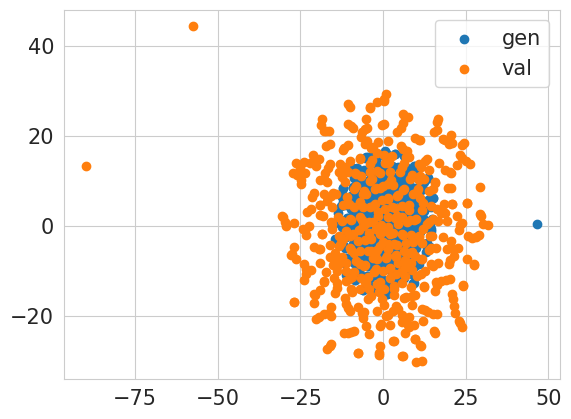

In [19]:
model = LanguageModel(train_set, rnn_type=nn.LSTM).to(device)
model.load_state_dict(torch.load('/content/simple_lstm.pt'))
_, matrix = custom_metric(model)
plot_tsne_of_matrix(matrix)

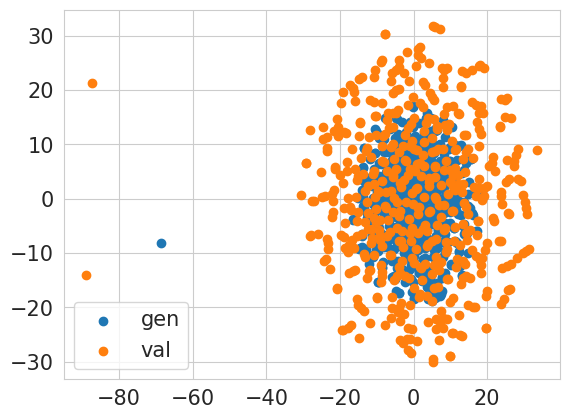

In [20]:
model = LanguageModel(train_set, rnn_type=nn.LSTM).to(device)
model.load_state_dict(torch.load('/content/lstm_5k_tokens.pt'))
_, matrix = custom_metric(model)
plot_tsne_of_matrix(matrix)

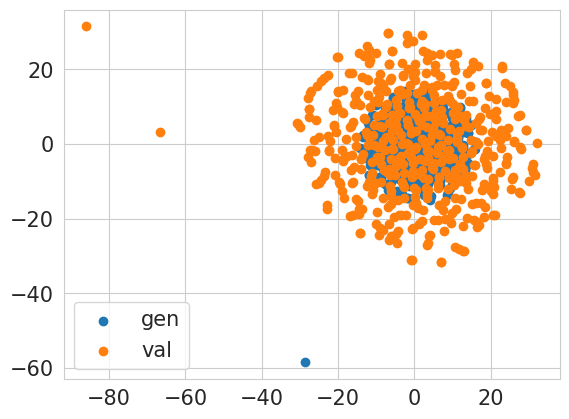

In [21]:
model = LanguageModel(train_set, rnn_type=nn.LSTM).to(device)
model.load_state_dict(torch.load('/content/lstm_unigram.pt'))
_, matrix = custom_metric(model)
plot_tsne_of_matrix(matrix)

## Задание 8. ruGPT perplexity (3.5 балла)

Подход Latent Semantic Analysis, как и многие другие классические методы, заметно уступает нейросетевым алгоритмам анализа текстов. Вернемся к оцениванию качества генерации с помощью perplexity, для этого возьмем большую и хорошо обученную языковую модель, которая училась на огромном корпусе русских текстов. Считается, что большие языковые модели хорошо выучивают естественный язык, потому с их помощью мы сможем оценивать качество наших маленьких моделей для генерации анекдотов. Для этого мы воспользуемся сервисом [HuggingFace](https://huggingface.co/), который содержит огромное число обученных моделей для самых разных задач. Изучите и реализуйте, [подсчет perplexity](https://huggingface.co/docs/transformers/perplexity), с использованием обученной языковой модели. В качестве модели возьмите [ruGPT3-small](https://huggingface.co/sberbank-ai/rugpt3small_based_on_gpt2). Сгенерируйте синтетические выборки тремя моделями, обученными выше (можете взять выборки из задания 6), и сравните их по perplexity.

прикольно, нужно просто вместо вал векторов научиться генерить векторы при помощи ruGPT3-small и далее проделать все те же шаги.

In [23]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
from tqdm import tqdm

def calc_ppl_with_LLM(filename):
  # подгружаем модель и токенайзер
  tokenizer = AutoTokenizer.from_pretrained("ai-forever/rugpt3small_based_on_gpt2")
  model = AutoModelForCausalLM.from_pretrained("ai-forever/rugpt3small_based_on_gpt2").to(device)

  # токенизируем текст
  with open(f"{filename}.txt", "r", encoding="utf-8") as file:
    corpus_text = file.read()

  encodings = tokenizer(corpus_text, return_tensors="pt")

  # считаем ppl, код взял с hugging faces
  max_length = model.config.n_positions
  stride = 512
  seq_len = encodings.input_ids.size(1)

  nlls = []
  prev_end_loc = 0
  for begin_loc in tqdm(range(0, seq_len, stride)):
      end_loc = min(begin_loc + max_length, seq_len)
      trg_len = end_loc - prev_end_loc  # may be different from stride on last loop
      input_ids = encodings.input_ids[:, begin_loc:end_loc].to(device)
      target_ids = input_ids.clone()
      target_ids[:, :-trg_len] = -100

      with torch.no_grad():
          outputs = model(input_ids, labels=target_ids)

          # loss is calculated using CrossEntropyLoss which averages over valid labels
          # N.B. the model only calculates loss over trg_len - 1 labels, because it internally shifts the labels
          # to the left by 1.
          neg_log_likelihood = outputs.loss

      nlls.append(neg_log_likelihood)

      prev_end_loc = end_loc
      if end_loc == seq_len:
          break

  ppl = torch.exp(torch.stack(nlls).mean())

  return ppl


In [24]:
def gen_jokes(filename, model, num_of_jokes) -> None:
  with open(f'{filename}.txt', 'w') as file:
    pass
  for i in range(num_of_jokes):
    anek = model.inference("", temp=np.random.uniform(0.1, 2))
    with open(f'{filename}.txt', 'a') as file:
      file.write(anek + '\n')

In [25]:
model = LanguageModel(train_set, rnn_type=nn.LSTM).to(device)
model.load_state_dict(torch.load('/content/simple_lstm.pt'))
filename = 'simple_lstm_jokes'
gen_jokes(filename, model, 6000)
calc_ppl_with_LLM(filename)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.25k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.71M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/574 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/720 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/551M [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (272075 > 2048). Running this sequence through the model will result in indexing errors
 99%|█████████▉| 528/532 [02:31<00:01,  3.48it/s]


tensor(947.3423, device='cuda:0')

In [26]:
model = LanguageModel(train_set, rnn_type=nn.LSTM).to(device)
model.load_state_dict(torch.load('/content/lstm_5k_tokens.pt'))
filename = 'lstm_5k_tokens_jokes'
gen_jokes(filename, model, 6000)
calc_ppl_with_LLM(filename)

Token indices sequence length is longer than the specified maximum sequence length for this model (271176 > 2048). Running this sequence through the model will result in indexing errors
 99%|█████████▉| 526/530 [02:34<00:01,  3.40it/s]


tensor(1061.0697, device='cuda:0')

In [27]:
model = LanguageModel(train_set, rnn_type=nn.LSTM).to(device)
model.load_state_dict(torch.load('/content/lstm_unigram.pt'))
filename = 'lstm_unigram_jokes'
gen_jokes(filename, model, 6000)
calc_ppl_with_LLM(filename)

Token indices sequence length is longer than the specified maximum sequence length for this model (307660 > 2048). Running this sequence through the model will result in indexing errors
 99%|█████████▉| 597/601 [02:55<00:01,  3.41it/s]


tensor(754.0968, device='cuda:0')

лучше всего ppl получился у текстов, сгенерированных после обучения на unigram токенизации

## Бонус (0.1 балл)

Покажите лучший анекдот, который удалось сгенерировать вашей модели. Если проверяющий найдет его смешным, то поставит 0.1 балла.